In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df =  pd.read_csv(r"C:\Users\HP\Desktop\DL\creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()

False

In [6]:
frauds=df[df.Class==1]

normal=df[df.Class==0]

In [7]:
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

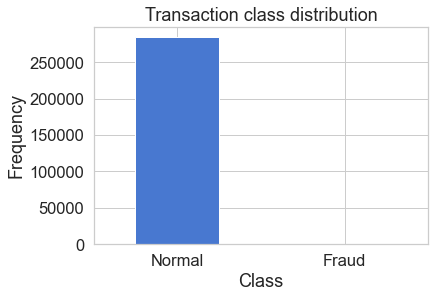

In [9]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

#no of normal class transaction are higher than fraud

In [10]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)                          #time has no rleation to model

#By standardizing the 'Amount' feature, you ensure that all features in your dataset have the same scale and distribution. 
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

#all features have the same scale or distribution. Standardizing the features can make the optimization process faster and more accurate 


In [11]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]              #training the model with only normal transactions

#dropping the 'Class' column from the training data since it represents the target variable (labels),
#and you want to use it separately as y_test.
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']                       #hold the true labels for the test data.

X_test = X_test.drop(['Class'], axis=1)

# converting the training and testing DataFrames into NumPy arrays.

X_train = X_train.values
X_test = X_test.values

In [12]:
X_train.shape

(227451, 29)

In [13]:
input_dim = X_train.shape[1]                 #discarded time and class attribute
print(input_dim)
encoding_dim = 14

#represents the number of neurons in the bottleneck or hidden layer of the encoder part of the network. This bottleneck layer is where the input data is compressed or encoded into a lower-dimensional representation.

29


In [14]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer) #to avoid overfitting to model it adds penalty when model as model opxicilty increses, and to generilize the data and not overfit
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [15]:
#trained the model with 10 epoch and batch size 32 and saved best performing model to a file


nb_epoch = 10
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', 
                                               restore_best_weights=True)

autoencoder.compile(optimizer='adam',       #addavpative learning rate optimization algo
                    loss='mean_squared_error', 
                    metrics=['accuracy'])


#saves the model's weights to a file named "model.h5" whenever the validation loss improves. 
#This allows you to save the best-performing model during training.
checkpointer = ModelCheckpoint(filepath="model.h5",                #provide fault tauralenace, stores the weight of model to make prediction in future
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',                    #measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

Epoch 1/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.8134 - accuracy: 0.5715 - val_loss: 0.7775 - val_accuracy: 0.6520
Epoch 2/10
  39/7108 [..............................] - ETA: 18s - loss: 0.7610 - accuracy: 0.6699

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 19s 3ms/step - loss: 0.7364 - accuracy: 0.6717 - val_loss: 0.7582 - val_accuracy: 0.6788
Epoch 3/10
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7241 - accuracy: 0.6826 - val_loss: 0.7499 - val_accuracy: 0.6916
Epoch 4/10
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7177 - accuracy: 0.6930 - val_loss: 0.7444 - val_accuracy: 0.7046
Epoch 5/10
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7132 - accuracy: 0.7058 - val_loss: 0.7409 - val_accuracy: 0.7174
Epoch 6/10
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7102 - accuracy: 0.7147 - val_loss: 0.7417 - val_accuracy: 0.7137
Epoch 7/10
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7079 - accuracy: 0.7185 - val_loss: 0.7394 - val_accuracy: 0.7263
Epoch 8/10
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7061 - accuracy: 0.7212 - val_loss: 0.7363 - val_accuracy: 0.7

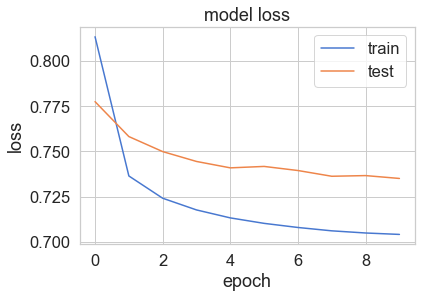

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [17]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 3s 2ms/step


In [18]:

#Anomalies are data points where the reconstruction loss is higher.
#To calculate the reconstruction loss on test data, predict the test data and calculate the mean square error between the test data and the reconstructed test data.
#Plotting the test data points and their respective reconstruction error sets a threshold value to visualize if the threshold value needs to be adjusted



mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [19]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.734319,0.001720
std,3.432661,0.041443
min,0.040486,0.000000
25%,0.236783,0.000000
50%,0.382171,0.000000
75%,0.617231,0.000000
max,256.248420,1.000000


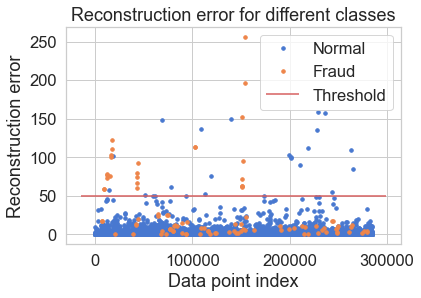

In [20]:
threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [21]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

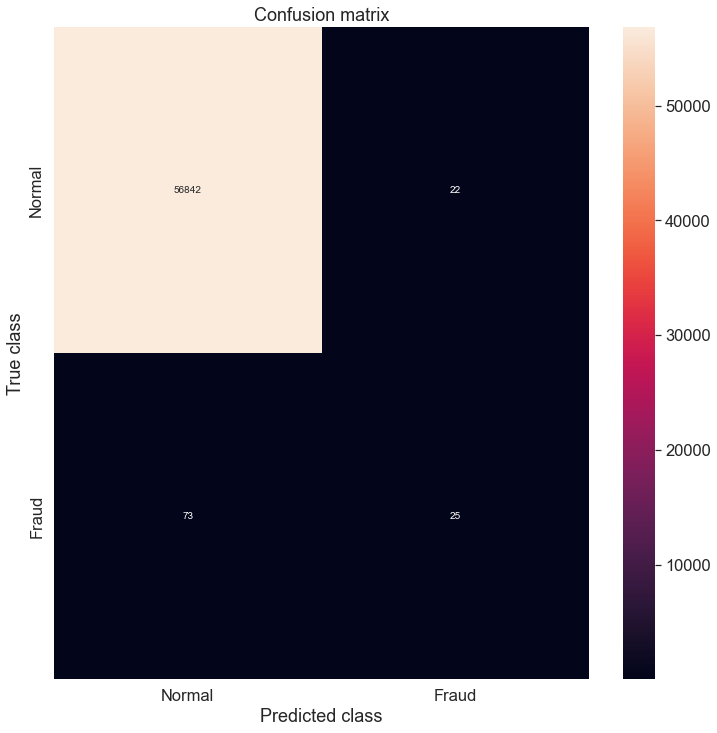

In [22]:

'''generates a list y_pred of predicted class labels (1 for anomalies or outliers and 0 for normal data points) 
based on a given threshold. It uses a list comprehension to iterate through the reconstruction_error values in the 
DataFrame error_df. 

If the reconstruction error for a data point is greater than the specified threshold, 
it assigns a predicted class label of 1; otherwise, it assigns a label of 0. 

This is a common approach in anomaly detection,
where data points with reconstruction errors above a certain threshold are classified as anomalies.'''




y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [23]:
error_df['pred'] = y_pred

In [24]:
print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred'])) 
print("Recall:",recall_score(error_df['true_class'],error_df['pred']))
print("Precision:",precision_score(error_df['true_class'],error_df['pred']))

Accuracy: 0.9983322214809873
Recall: 0.25510204081632654
Precision: 0.5319148936170213


Autoencoders are a type of artificial neural network used for various tasks, including dimensionality reduction, feature learning, and anomaly detection. Anomaly detection using autoencoders is a common application where the model learns to represent normal data and identify anomalies by measuring the reconstruction error. Here's an explanation of how autoencoders can be used for anomaly detection:

1. Autoencoder Architecture:
   An autoencoder is a neural network architecture consisting of an encoder and a decoder. The encoder compresses the input data into a lower-dimensional representation, often called a latent space, and the decoder reconstructs the input data from this compressed representation. The architecture typically looks like this:
   
   Input Data -> Encoder -> Latent Space -> Decoder -> Reconstructed Data

2. Training with Normal Data:
   To perform anomaly detection, you first need to train the autoencoder on a dataset that contains only normal data samples. During training, the autoencoder learns to represent the normal data distribution by minimizing the reconstruction error between the input data and the reconstructed data.

3. Reconstruction Error:
   The reconstruction error is calculated as the difference between the input data and the output of the autoencoder (reconstructed data). A low reconstruction error indicates that the autoencoder can accurately reconstruct the normal data, while a high reconstruction error suggests anomalies or deviations from the learned normal patterns.

4. Anomaly Detection:
   After training on normal data, the autoencoder can be used for anomaly detection as follows:
   
   - When you pass a new data sample through the trained autoencoder, it will reconstruct the data.
   - Calculate the reconstruction error for the new data sample.
   - A high reconstruction error (above a predefined threshold) indicates that the input data is an anomaly, as it could not be accurately reconstructed using the learned normal patterns.

5. Setting a Threshold:
   To make the anomaly detection practical, you need to set a threshold above which the reconstruction error is considered indicative of an anomaly. This threshold can be determined using various techniques, such as statistical methods or domain-specific knowledge. Cross-validation or visual inspection of the error distribution can also help.

6. Anomaly Detection in Practice:
   In practice, autoencoders are particularly effective for detecting anomalies in data that have a clear structure, where anomalies represent deviations from this structure. For example, in image data, anomalies might be unusual visual patterns or corruptions in the image. In tabular data, anomalies can be values that are significantly different from the norm.

Autoencoders are versatile and can be adapted to various data types, making them a valuable tool for anomaly detection. However, it's essential to have a labeled dataset for training the autoencoder on normal data and to carefully choose the threshold for anomaly detection to balance false positives and false negatives in your specific application.